Epoch[1/25], G Loss: -0.3555, D Loss: -2.1912


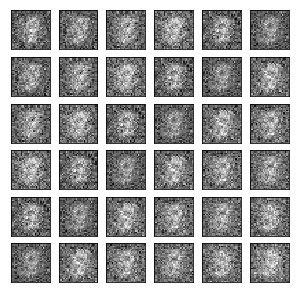

Epoch[2/25], G Loss: -0.1451, D Loss: -0.6717


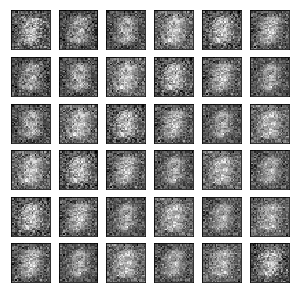

Epoch[3/25], G Loss: -0.1017, D Loss: -0.4796


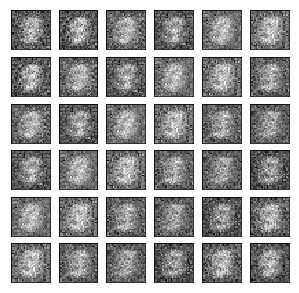

Epoch[4/25], G Loss: -0.1144, D Loss: -0.0374


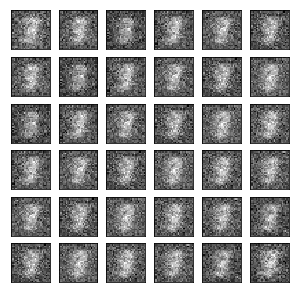

Epoch[5/25], G Loss: -0.1613, D Loss: 1.4653


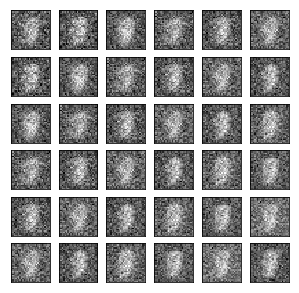

Epoch[6/25], G Loss: -0.3970, D Loss: 1.3611


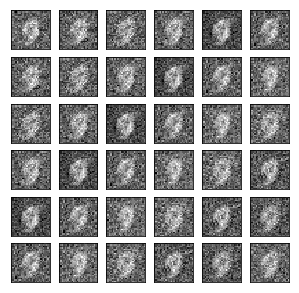

Epoch[7/25], G Loss: -0.5763, D Loss: 0.3105


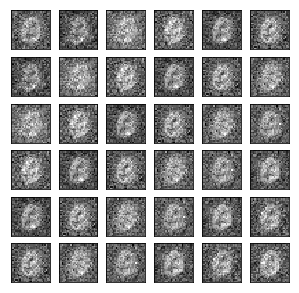

Epoch[8/25], G Loss: -0.3014, D Loss: -0.0439


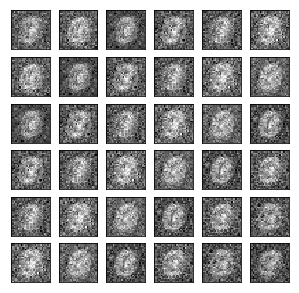

Epoch[9/25], G Loss: -0.4547, D Loss: -1.7652


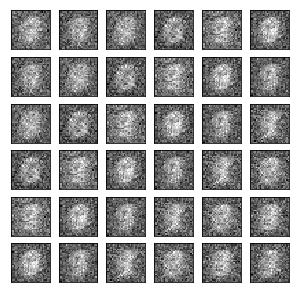

Epoch[10/25], G Loss: -1.4919, D Loss: -1.8566


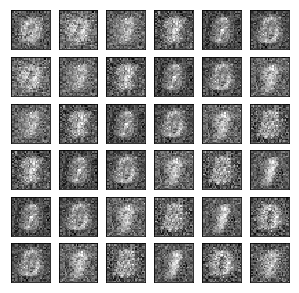

Epoch[11/25], G Loss: -2.1874, D Loss: -1.2997


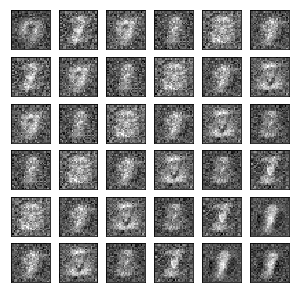

Epoch[12/25], G Loss: -1.5765, D Loss: -1.3127


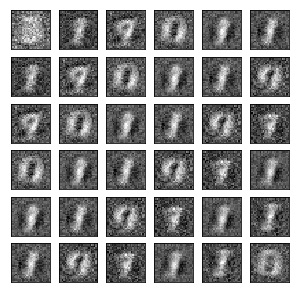

Epoch[13/25], G Loss: -0.8830, D Loss: -1.8004


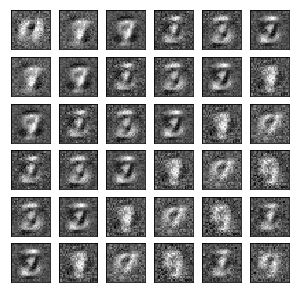

Epoch[14/25], G Loss: -0.9266, D Loss: -1.9366


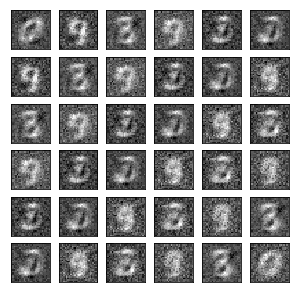

Epoch[15/25], G Loss: -1.0883, D Loss: -1.6899


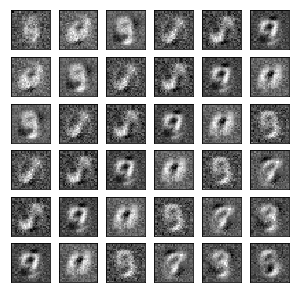

Epoch[16/25], G Loss: -1.8244, D Loss: -1.5177


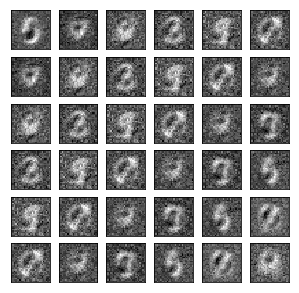

Epoch[17/25], G Loss: -1.7927, D Loss: -1.5775


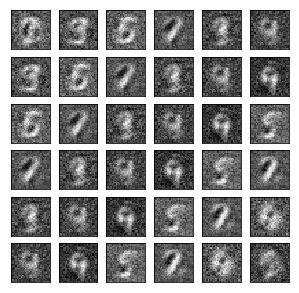

Epoch[18/25], G Loss: -1.8319, D Loss: -1.7571


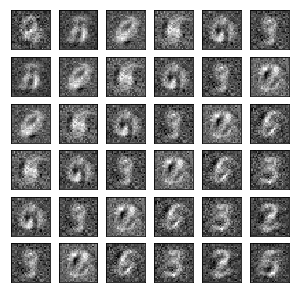

Epoch[19/25], G Loss: -1.8484, D Loss: -1.6271


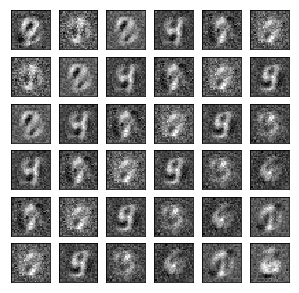

Epoch[20/25], G Loss: -2.2253, D Loss: -1.4030


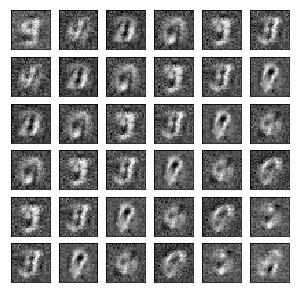

Epoch[21/25], G Loss: -1.8896, D Loss: -1.5754


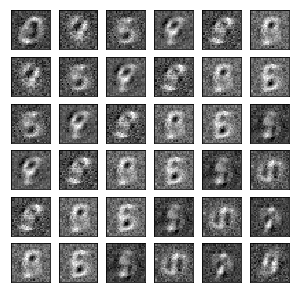

Epoch[22/25], G Loss: -1.8278, D Loss: -1.5189


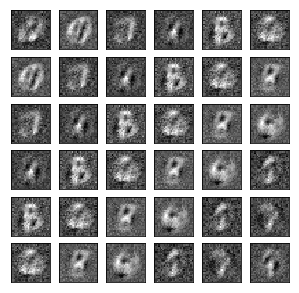

Epoch[23/25], G Loss: -1.4597, D Loss: -1.5739


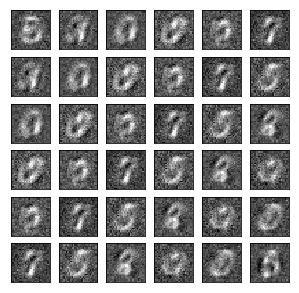

Epoch[24/25], G Loss: -1.3704, D Loss: -1.6076


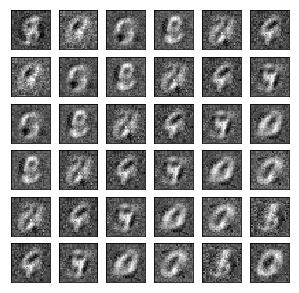

Epoch[25/25], G Loss: -1.4459, D Loss: -1.6069


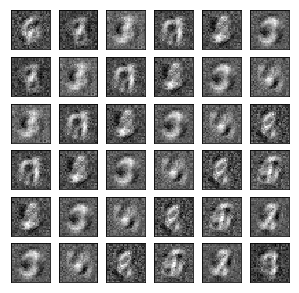

In [2]:
""" (LS GAN)
Least Squares GAN

https://arxiv.org/pdf/1611.04076.pdf

The output of LSGAN's G is unbounded unless passed through an activation function.
We do not use any such activation functions in this implementation.

Tackles the vanishing gradients problem associated with GANs by swapping out
the cross entropy loss function with the least squares (L2) loss function. The authors
show that minimizing this objective is equivalent to minimizing the Pearson chi-squared 
divergence. They claim that using the L2 loss function penalizes samples that appear to 
be real to the discriminator, but lie far away from the decision boundary. In this way, 
the generated images are made to appear closer to real data. It also stabilizes training.
"""

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from tqdm import tqdm_notebook
from load_data import get_data

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()


class Generator(nn.Module):
    """ Generator. Input is noise, output is a generated image. 
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()
        
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = self.generate(activated)
        return generation


class Discriminator(nn.Module):
    """ Critic (not trained to classify). Input is an image (real or generated), 
    output is the approximate Wasserstein Distance between z~P(G(z)) and real.
    """
    def __init__(self, image_size, hidden_dim, output_dim):
        super().__init__()
        
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = F.sigmoid(self.discriminate(activated))
        return discrimination


class LSGAN(nn.Module):
    """ Super class to contain both Discriminator (D) and Generator (G) 
    """
    def __init__(self, image_size, hidden_dim, z_dim, output_dim=1):
        super().__init__()
        
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim


class Trainer:
    """ Object to hold data iterators, train a GAN variant 
    """
    def __init__(self, model, train_iter, val_iter, test_iter):
        self.model = to_cuda(model)
        self.name = model.__class__.__name__
        
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
        
        self.Glosses = []
        self.Dlosses = []

    def train(self, num_epochs, G_lr=1e-4, D_lr=1e-4, D_steps=5):
        """ Train a Wasserstein GAN with Gradient Penalty
            Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

        Inputs:
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 5e-5)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 5e-5)
            D_steps: int, training step ratio for how often to train D compared to G (default 5)
        """
        # Initialize optimizers
        G_optimizer = torch.optim.Adam(params=[p for p in self.model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in self.model.D.parameters() if p.requires_grad], lr=D_lr)
    
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            self.model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                for _ in range(D_steps): 

                    # Reshape images
                    images = self.process_batch(self.train_iter)

                    # TRAINING D: Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator to approximate the Wasserstein distance between real, generated
                    # distributions                    
                    D_loss = self.train_D(images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss.item())
                                                        
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G
                G_optimizer.zero_grad()

                # Train the generator to (roughly) minimize the approximated Wasserstein distance
                G_loss = self.train_G(images)
                
                # Log results, update parameters
                G_losses.append(G_loss.item())
                G_loss.backward()
                G_optimizer.step()
            
            # Save progress
            self.Glosses.extend(G_losses)
            self.Dlosses.extend(D_losses)
                            
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses))) 
            
            # Visualize generator progress
            self.generate_images(epoch)
            plt.show()
        
    def train_D(self, images, LAMBDA=10):
        """ Run 1 step of training for discriminator

        Input:
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: wasserstein loss for discriminator, -E[D(x)] + E[D(G(z))] + λE[(||∇ D(εx + (1 − εG(z)))|| - 1)^2]
        """   
        
        # ORIGINAL CRITIC STEPS:
        # Sample noise, an output from the generator
        noise = self.compute_noise(images.shape[0], self.model.z_dim)
        G_output = self.model.G(noise)
        
        # Use the discriminator to sample real, generated images
        DX_score = self.model.D(images) # D(z)
        DG_score = self.model.D(G_output) # D(G(z))
        
        # GRADIENT PENALTY:
        # Uniformly sample along one straight line per each batch entry. 
        epsilon = to_cuda(torch.rand(images.shape[0], 1).expand(images.size()))

        # Generate images from the noise, ensure unit gradient norm 1
        # See Section 4 and Algorithm 1 of original paper for full explanation.
        G_interpolation = epsilon*images + (1-epsilon)*G_output # negation doesn't matter; we square later on
        D_interpolation = self.model.D(G_interpolation)

        # Compute the gradients of D with respect to the noise generated input
        weight = to_cuda(torch.ones(D_interpolation.size()))
            
        gradients = torch.autograd.grad(outputs=D_interpolation, 
                                        inputs=G_interpolation,
                                        grad_outputs=weight,
                                        only_inputs=True,
                                        create_graph=True,
                                        retain_graph=True)[0]

        # Full gradient penalty
        grad_penalty = LAMBDA * torch.mean((gradients.norm(2, dim = 1) - 1) **2)
        
        # Compute WGAN-GP loss for D
        D_loss = torch.mean(DG_score) - torch.mean(DX_score) + grad_penalty
        
        return D_loss
    
    def train_G(self, images):
        """ Run 1 step of training for generator
        
        Input:
            images: batch of images reshaped to [batch_size, -1]    
        Output:
            G_loss: wasserstein loss for generator, -E[D(G(z))]
        """   
        # Get noise, classify it using G, then classify the output of G using D.
        noise = self.compute_noise(images.shape[0], self.model.z_dim) # z
        G_output = self.model.G(noise) # G(z)
        DG_score = self.model.D(G_output) # D(G(z))
        
        # Compute WGAN-GP loss for G (same loss as WGAN)
        G_loss = -1 * (torch.mean(DG_score))
        
        return G_loss
    
    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_cuda(torch.randn(batch_size, z_dim))
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_cuda(images.view(images.shape[0], -1))
        return images
    
    def generate_images(self, epoch, num_outputs=36, save=True):
        """ Visualize progress of generator learning """
        # Turn off any regularization
        self.model.eval()
        
        # Sample noise vector
        noise = self.compute_noise(num_outputs, self.model.z_dim)
        
        # Transform noise to image
        images = self.model.G(noise)
        
        # Reshape to proper image size
        images = images.view(images.shape[0], 28, 28)
        
        # Plot
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        # Save images if desired
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.unsqueeze(1).data.cpu(), 
                                         outname + 'reconst_%d.png'
                                         %(epoch), nrow = 5)
    
    def viz_loss(self):
        """ Visualize loss for the generator, discriminator """
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (8,6)

        plt.plot(self.Dlosses, 'r')
        plt.plot(self.Glosses, 'g')
        
        plt.legend(['Discriminator', 'Generator'])
        plt.title(self.name)
        plt.show()

    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)
    
    def load_model(self, loadpath):
        """ Load state dictionary into model """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)


model = WGANGP(image_size=784, 
              hidden_dim=256, 
              z_dim=128)

trainer = Trainer(model=model, 
                  train_iter=train_iter, 
                  val_iter=val_iter, 
                  test_iter=test_iter)

trainer.train(num_epochs=25,
              G_lr=1e-4,
              D_lr=1e-4,
              D_steps=5)